# **Disease Prediction from Symptoms**


# **Libraries**

In [ ]:
# Import Dependencies
import csv
import pandas as pd
import numpy as np
from collections import defaultdict
#processing
# Encode the Labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#training
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# **Dataset**

In [ ]:
# Read Raw Dataset
df = pd.read_excel('data/raw_data.xlsx')
# Fill all NaN with the values above
data = df.ffill()
print("row data size:",np.shape(data))
print("count of unique disese type:",len(np.unique(data['Disease'])))
print("count of unique symptom type:",len(np.unique(data['Symptom'])))

row data size: (1866, 3)
count of unique disese type: 134
count of unique symptom type: 401


In [ ]:
data.head()

,Disease,Count of Disease Occurrence,Symptom
0,UMLS:C0020538_hypertensive disease,3363.0,UMLS:C0008031_pain chest
1,UMLS:C0020538_hypertensive disease,3363.0,UMLS:C0392680_shortness of breath
2,UMLS:C0020538_hypertensive disease,3363.0,UMLS:C0012833_dizziness
3,UMLS:C0020538_hypertensive disease,3363.0,UMLS:C0004093_asthenia
4,UMLS:C0020538_hypertensive disease,3363.0,UMLS:C0085639_fall


# **Preprocess**

In [ ]:
# Process Disease and Symptom Names
# example: it converts [UMLS:C0006142_malignant neoplasm of breast^UMLS:C0678222_carcinoma breast] to ['malignant neoplasm of breast', 'carcinoma breast']
def process_data(data):
    data_list = []
    #replace ^ with _ then split from _
    data = data.replace("\xa0",' ')
    data_name = data.replace('^','_').split('_')

    #just keep even words of a list
    n = 1
    for names in data_name:
        if (n % 2 == 0):
            data_list.append(names)
        n += 1
    return data_list

In [ ]:
# Data Cleanup
# make two dictionaries of datas 1.with names of disease and lists of symptoms 2.with names of disease and count of occurrence
#output example:
#1. {'hypertensive disease': ['pain chest','shortness of breath','dizziness','asthenia','fall', 'syncope','vertigo','sweat','sweating increased','palpitation','nausea','angina pectoris','pressure chest'],...
#2.'hypertensive disease': 3363.0,'diabetes': 1421.0,.....

disease_list = []
disease_symptom_dict = defaultdict(list)
disease_symptom_count = {}
count = 0

for idx, row in data.iterrows():

    # Get the Disease Names
    disease = row['Disease']
    disease_list = process_data(data=disease)
    count = row['Count of Disease Occurrence']

    # Get the Symptoms Corresponding to Diseases
    symptom = row['Symptom']
    symptom_list = process_data(data=symptom)
    d = disease_list[0]
    for s in symptom_list:
      disease_symptom_dict[d].append(s)
    disease_symptom_count[d] = count

In [ ]:
# Save cleaned data as CSV
f = open('data/cleaned_data.csv', 'w')

with f:
    writer = csv.writer(f)
    for key, val in disease_symptom_dict.items():
        for i in range(len(val)):
            writer.writerow([key, val[i], disease_symptom_count[key]])

# **Encoding data**

In [ ]:
# Read Cleaned Data as DF
df = pd.read_csv('data/cleaned_data.csv')
df.columns = ['disease', 'symptom', 'occurence_count']
#count nan items
print("count of nan items:\n",np.sum(df.isna(),axis=0))
# Remove any rows with empty values
df.replace(float('nan'), np.nan, inplace=True)
df.dropna(inplace=True)
df = df.reset_index(drop=True)
print("data size:",np.shape(df))
print("count of unique disese type:",len(np.unique(df['disease'])))
print("count of unique symptom type:",len(np.unique(df['symptom'])))


count of nan items:
 disease            0
symptom            1
occurence_count    0
dtype: int64
data size: (1906, 3)
count of unique disese type: 133
count of unique symptom type: 404


In [ ]:
'''
In this phase, we want to convert the dataset to a new one which first makes a data frame
that its rows are the same as the previous one(1906) and its columns are all symptoms, so it is a data frame of (1906,404).
'''
label_encoder = LabelEncoder()
symptom_integer_encoded = label_encoder.fit_transform(df['symptom'])
print(np.shape(symptom_integer_encoded))
symptom_integer_encoded = symptom_integer_encoded.reshape(len(symptom_integer_encoded), 1)
print(np.shape(symptom_integer_encoded))

(1906,)
(1906, 1)


In [ ]:
print("data frame shape:",np.shape(symptom_integer_encoded))
df.head()

data frame shape: (1906, 1)


,disease,symptom,occurence_count
0,hypertensive disease,shortness of breath,3363.0
1,hypertensive disease,dizziness,3363.0
2,hypertensive disease,asthenia,3363.0
3,hypertensive disease,fall,3363.0
4,hypertensive disease,syncope,3363.0


In [ ]:
# One Hot Encode the Labels
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(symptom_integer_encoded)
cols = np.asarray(df['symptom'].unique())

In [ ]:
# Create a new dataframe to save OHE labels
df_ohe = pd.DataFrame(columns = cols)
for i in range(len(onehot_encoded)):
    df_ohe.loc[i] = onehot_encoded[i]

np.shape(df_ohe)

(1906, 404)

In [ ]:
# Disease Dataframe
df_disease = df['disease']
# Concatenate OHE Labels with the Disease Column
df_concat = pd.concat([df_disease,df_ohe], axis=1)
print(np.shape(df_concat))
#df_concat.drop_duplicates(keep='first',inplace=True)
df_concat.head()

(1906, 405)


,disease,shortness of breath,dizziness,asthenia,fall,syncope,vertigo,sweat,sweating increased,palpitation,...,feces in rectum,prodrome,hypoproteinemia,alcohol binge episode,abdomen acute,air fluid level,catching breath,large-for-dates fetus,immobile,homicidal thoughts
0,hypertensive disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,hypertensive disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,hypertensive disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,hypertensive disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,hypertensive disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'''
Since every disease has multiple symptoms, combine all symptoms per disease per row,
So in the new data frame, we have unique diseases and each symptom in a row so its shape is (133*404)
'''
df_concat = df_concat.groupby('disease').sum()
df_concat = df_concat.reset_index()
print("data frame shape:",np.shape(df_concat))
df_concat[:5]

data frame shape: (133, 405)


,disease,shortness of breath,dizziness,asthenia,fall,syncope,vertigo,sweat,sweating increased,palpitation,...,feces in rectum,prodrome,hypoproteinemia,alcohol binge episode,abdomen acute,air fluid level,catching breath,large-for-dates fetus,immobile,homicidal thoughts
0,Alzheimer's disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Pneumocystis carinii pneumonia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,accident cerebrovascular,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,acquired immuno-deficiency syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,adenocarcinoma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_concat.to_csv("/data/training_dataset.csv", index=False)

# **Model Training**

In [ ]:
# Read Encoded Data as DF
df_concat = pd.read_csv('data/training_dataset.csv')

In [ ]:
cols = df_concat.columns[1:]

# One Hot Encoded Features
X = df_concat[cols]

# Labels
y = df_concat['disease']

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
len(X_train), len(y_train),len(X_test), len(y_test)

(106, 106, 27, 27)

In [ ]:
# Training multinomial naive bayes
mnb = MultinomialNB()
mnb = mnb.fit(X_train, y_train)
print('\nAccuracy Train: ',mnb.score(X_train, y_train))
print('\nAccuracy Test: ',mnb.score(X_test,y_test))


Accuracy Train:  1.0

Accuracy Test:  0.0


In [ ]:
# Training decision trees
dt = DecisionTreeClassifier(criterion='entropy')
clf = dt.fit(X_train, y_train)
print('\nAccuracy Train: ',clf.score(X_train, y_train))
print('\nAccuracy Test: ',clf.score(X_test,y_test))


Accuracy Train:  1.0

Accuracy Test:  0.0


when the data is split into the train and test, We have never seen the disease in the test set, so we cannot function on data we have not seen. Also, there is only one score for each disease, so we do not have this score. Therefore, the model must be fully trained.

## Multinomial Naive Bayes

In [ ]:
mnb_tot = MultinomialNB()
mnb_tot = mnb_tot.fit(X, y)

print("Acurracy: ", mnb_tot.score(X, y))

disease_pred = mnb_tot.predict(X)
disease_real = y.values

# printing model error
for i in range(0, len(disease_real)):
    if disease_pred[i]!=disease_real[i]:
        print ('Pred: {0} Actual:{1}'.format(disease_pred[i], disease_real[i]))


Acurracy:  1.0


## Decision Trees

In [ ]:
dt = DecisionTreeClassifier()
clf_dt = dt.fit(X,y)

print ("Acurracy: ", clf_dt.score(X,y))

disease_pred = clf_dt.predict(X)
disease_real = y.values


for i in range(0, len(disease_real)):
    if disease_pred[i]!=disease_real[i]:
        print ('Pred: {0}\nActual: {1}\n'.format(disease_pred[i], disease_real[i]))

Acurracy:  1.0


In [ ]:
!pip install graphviz

In [ ]:
from graphviz import Source
from sklearn import tree

The entire decision tree is too big to be displayed here, so only a part of it is shown here. The entire decision tree is saved in tree.dot file.

In [ ]:
export_graphviz(dt,
                out_file='tree.dot',
                feature_names=cols)

In [ ]:
graph = Source(export_graphviz(dt,
               out_file=None,
               feature_names=cols,
               max_depth = 5))

png_bytes = graph.pipe(format='png')

with open('images/tree.png','wb') as f:
    f.write(png_bytes)

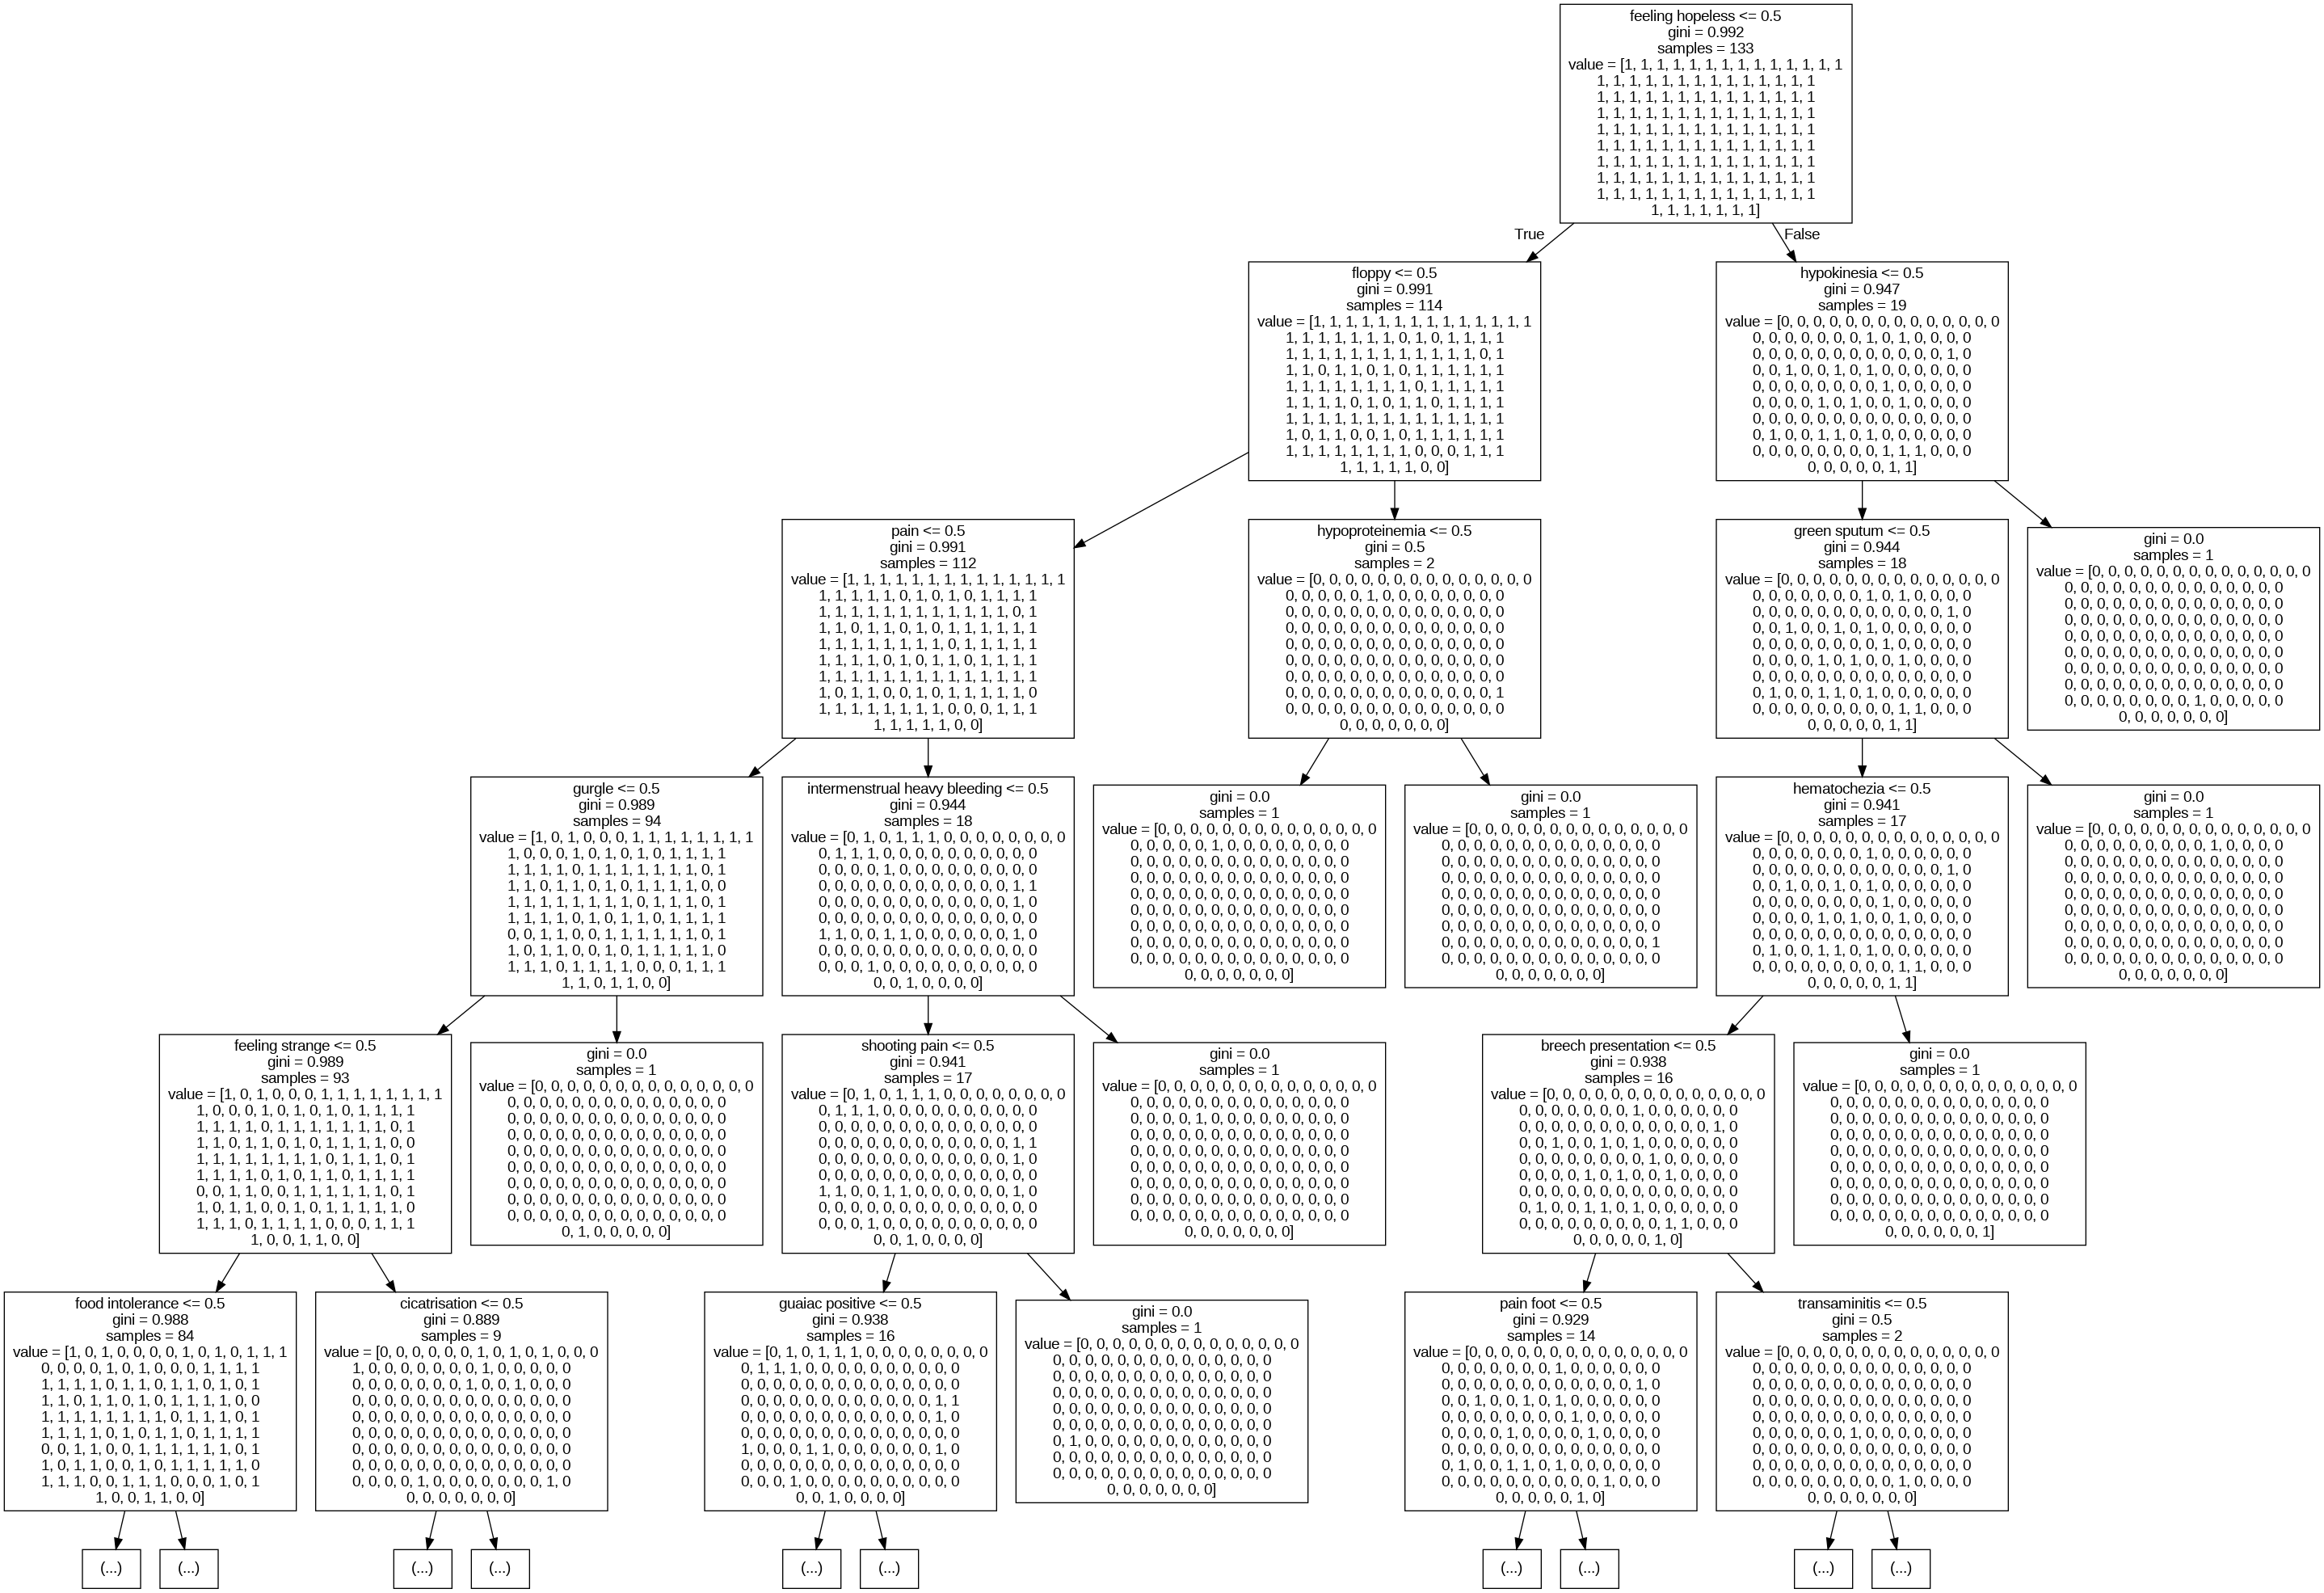

In [ ]:
from IPython.display import Image
Image(png_bytes)

In [ ]:
dt.__getstate__()

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'feature_names_in_': array(['shortness of breath', 'dizziness', 'asthenia', 'fall', 'syncope',
        'vertigo', 'sweat', 'sweating increased', 'palpitation', 'nausea',
        'angina pectoris', 'pressure chest', 'polyuria', 'polydypsia',
        'pain chest', 'orthopnea', 'rale', 'unresponsiveness',
        'mental status changes', 'vomiting', 'labored breathing',
        'feeling suicidal', 'suicidal', 'hallucinations auditory',
        'feeling hopeless', 'weepiness', 'sleeplessness',
        'motor retardation', 'irritable mood', 'blackout',
        'mood depressed', 'hallucinations visual', 'worry', 'agitation',
        'tremor', 'intoxication', 'verbal auditory hallucinations',
        'energ